In [25]:
%reset -sf

import pandas as pd
import numpy as np
import get_data as gd
import atlas_plot as ap
import gc

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [26]:
np.random.seed(42)  # set random seed
sampling = int(1e5)
processor = gd.DataProcessor(sampling=sampling)
path = "/root/work/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

['/root/work/truth/signal/CGLMP.npz', '/root/work/truth/signal/Higgs.npz', '/root/work/truth/signal/LeadLepton.npz', '/root/work/truth/signal/LeptonM.npz', '/root/work/truth/signal/LeptonP.npz', '/root/work/truth/signal/LmNu.npz', '/root/work/truth/signal/LpNu.npz', '/root/work/truth/signal/MET.npz', '/root/work/truth/signal/WmBoson.npz', '/root/work/truth/signal/WpBoson.npz', '/root/work/truth/signal/diLepton.npz', '/root/work/truth/signal/subLeadLepton.npz', '/root/work/truth/signal/xi_xyz.npz']



In [27]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [28]:
# y -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
MET_kin = pd.concat([MET, lep_kin], axis=1)
print("MET_kin shape:", MET_kin.shape)
print(MET_kin.head(3))
print()

# x -> interested unknowns
# cglmp = pd.DataFrame(processor.process_dipart(data.LepP, data.LepM)["pz"][cut_pre])
cglmp = pd.DataFrame(processor.process_CGLMP(data.CGLMP)["Bxy"][cut_pre])
print("cglmp shape:", cglmp.shape)
print(cglmp.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

MET_kin shape: (46534, 10)
      MET_px     MET_py           E         px         py         pz  \
0  60.642250  36.447252  464.288437   4.263841   9.776126  18.908787   
1  12.252621 -19.182246   59.009055 -40.845941 -18.534502  62.852781   
5   0.077834 -58.004250   10.840157 -47.734281  29.193326   5.581535   

            E        px         py          pz  
0  530.047688 -4.855100 -30.018883   -6.031029  
1   20.418521  9.270717  14.180011  256.081469  
5   67.553516 -3.257561   7.166547    2.536847  

cglmp shape: (46534, 1)
        Bxy
0 -0.376254
1 -0.981607
5  9.235420



0

In [29]:
from sklearn.preprocessing import StandardScaler

SCALAR_int = StandardScaler()
norm_var = SCALAR_int.fit_transform(cglmp)
cglmp = norm_var

SCALAR_MET = StandardScaler()
norm_var = SCALAR_MET.fit_transform(MET_kin)
MET_kin = norm_var

del norm_var

from sklearn.model_selection import train_test_split

indices_arr = np.arange(cglmp.shape[0], dtype="int")
indices_arr = np.random.choice(indices_arr, sampling)
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(), train_size=0.8, test_size=0.2, random_state=42
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=42
)

train_x = cglmp[train_indices]
valid_x = cglmp[valid_indices]
test_x = cglmp[test_indices]
train_y = MET_kin[train_indices]
valid_y = MET_kin[valid_indices]
test_y = MET_kin[test_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

X (Interest)
Training data shape: (80000, 1);
Validing data shape: (10000, 1);
Testing data shape: (10000, 1).
Y (Observed)
Training data shape: (80000, 10);
Validing data shape: (10000, 10);
Testing data shape: (10000, 10).



In [39]:
def build_model():
    model = keras.models.Sequential()

    # encoder
    model.add(layers.Flatten(input_shape=(train_y.shape[-1],)))
    # model.add(layers.Dense(units=16, activation="relu"))
    model.add(layers.Dense(units=8, activation="relu"))
    model.add(layers.Dense(units=4, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # bottleneck
    model.add(layers.Dense(units=2, activation="relu"))
    # decoder
    model.add(layers.Dense(units=4, activation="relu"))
    model.add(layers.Dense(units=8, activation="relu"))
    # model.add(layers.Dense(units=16, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Last dense layers
    # model.add(layers.Dense(units=8, activation="relu"))
    # model.add(layers.Dense(units=4, activation="relu"))
    model.add(layers.Dense(units=1, activation="linear"))

    # Compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss="mse")
    model.summary()

    return model

In [40]:
model = build_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 10)                0         
                                                                 
 dense_28 (Dense)            (None, 8)                 88        
                                                                 
 dense_29 (Dense)            (None, 4)                 36        
                                                                 
 batch_normalization_10 (Ba  (None, 4)                 16        
 tchNormalization)                                               
                                                                 
 re_lu_10 (ReLU)             (None, 4)                 0         
                                                                 
 dense_30 (Dense)            (None, 2)                 10        
                                                      

In [41]:
# Load the TensorBoard notebook extension.
import datetime

# set log file
%rm -r ./logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# set callback of tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=5, write_graph=True, write_images=False,)

stop_early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Fit the model
history = model.fit(
    x=train_y,
    y=train_x,
    validation_data=(valid_y, valid_x),
    epochs=64,
    batch_size=128,
    verbose=2,
    callbacks=[stop_early, tensorboard_callback],
)

Epoch 1/64
625/625 - 5s - loss: 1.2177 - val_loss: 1.1691 - 5s/epoch - 8ms/step
Epoch 2/64
625/625 - 3s - loss: 1.1665 - val_loss: 1.1459 - 3s/epoch - 5ms/step
Epoch 3/64
625/625 - 3s - loss: 1.1259 - val_loss: 1.1026 - 3s/epoch - 4ms/step
Epoch 4/64
625/625 - 3s - loss: 1.0925 - val_loss: 1.0705 - 3s/epoch - 4ms/step
Epoch 5/64
625/625 - 3s - loss: 1.0632 - val_loss: 1.0431 - 3s/epoch - 4ms/step
Epoch 6/64
625/625 - 3s - loss: 1.0401 - val_loss: 1.0195 - 3s/epoch - 4ms/step
Epoch 7/64
625/625 - 3s - loss: 1.0206 - val_loss: 1.0019 - 3s/epoch - 4ms/step
Epoch 8/64
625/625 - 3s - loss: 1.0078 - val_loss: 0.9928 - 3s/epoch - 5ms/step
Epoch 9/64
625/625 - 3s - loss: 1.0020 - val_loss: 0.9882 - 3s/epoch - 4ms/step
Epoch 10/64
625/625 - 3s - loss: 0.9998 - val_loss: 0.9864 - 3s/epoch - 4ms/step
Epoch 11/64
625/625 - 3s - loss: 0.9993 - val_loss: 0.9861 - 3s/epoch - 4ms/step
Epoch 12/64
625/625 - 3s - loss: 0.9989 - val_loss: 0.9858 - 3s/epoch - 4ms/step
Epoch 13/64
625/625 - 3s - loss: 0.99

In [42]:
x_pred = model.predict(test_y)
pred = x_pred.flatten()
truth = test_x.flatten()

313/313 [==============================] - 1s 1ms/step


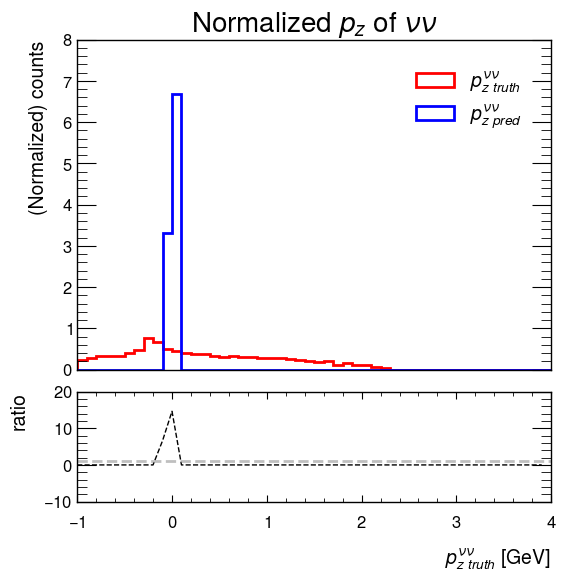

<Figure size 800x600 with 0 Axes>

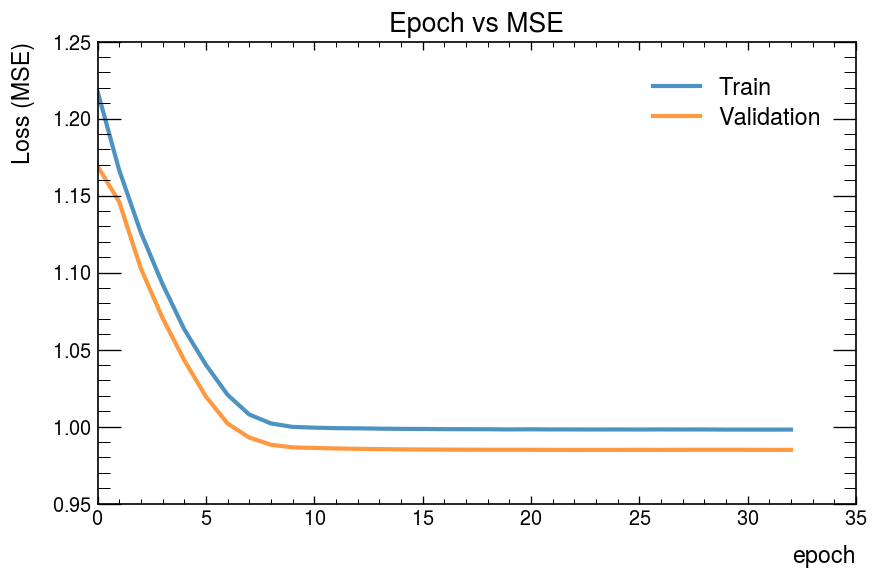

<Figure size 800x600 with 0 Axes>

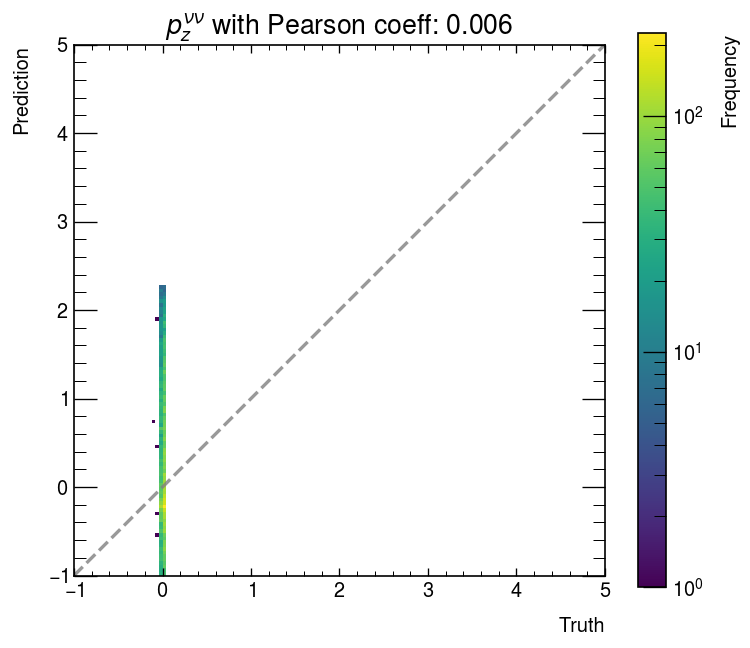

<Figure size 800x600 with 0 Axes>

In [43]:
plot = ap.Plotter()

plot.plot_hist(
    [truth, pred],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    r"Normalized $p_{z}$ of $\nu\nu$",
    [-1, 4],
)
plot.plot_loss_history(history)

import scipy as sp

plot.plot_2d_histogram(
    pred,
    truth,
    r"$p_{z}^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(truth, pred)[0]:.3f}",
    range=[-1, 5],
)

In [44]:
# Background

processor = gd.DataProcessor(sampling=sampling)
path = "/root/work/truth/background/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

['/root/work/truth/background/CGLMP.npz', '/root/work/truth/background/Higgs.npz', '/root/work/truth/background/LeadLepton.npz', '/root/work/truth/background/LeptonM.npz', '/root/work/truth/background/LeptonP.npz', '/root/work/truth/background/LmNu.npz', '/root/work/truth/background/LpNu.npz', '/root/work/truth/background/MET.npz', '/root/work/truth/background/WmBoson.npz', '/root/work/truth/background/WpBoson.npz', '/root/work/truth/background/diLepton.npz', '/root/work/truth/background/subLeadLepton.npz', '/root/work/truth/background/xi_xyz.npz']



In [45]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [46]:
# y -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
MET_kin = pd.concat([MET, lep_kin], axis=1)
print("MET_kin shape:", MET_kin.shape)
print(MET_kin.head(3))
print()

# x -> interested unknowns
cglmp = pd.DataFrame(processor.process_CGLMP(data.CGLMP)["Bxy"][cut_pre])
print("cglmp shape:", cglmp.shape)
print(cglmp.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

MET_kin shape: (67474, 10)
      MET_px     MET_py           E         px         py          pz  \
0  -5.599501  30.856795   77.563547 -53.639004 -28.213439   54.762293   
1  24.145186  46.287402  117.575063  35.735621   8.846024   69.659672   
5  44.660847  32.867593   93.244938 -34.129469 -19.548094 -217.460813   

            E         px         py         pz  
0  124.146219  57.952746  13.767107  36.583723  
1  227.310703 -37.518801 -26.830068 -18.753611  
5   55.692637   0.345160  36.526414 -92.072414  

cglmp shape: (67474, 1)
       Bxy
0 -2.03818
1 -0.78290
5  6.88378



33405

In [47]:
SCALAR_int_bkg = StandardScaler()
norm_var = SCALAR_int.fit_transform(cglmp)
cglmp = norm_var

SCALAR_MET_bkg = StandardScaler()
norm_var = SCALAR_MET.fit_transform(MET_kin)
MET_kin = norm_var

del norm_var

x, y = cglmp[test_indices], MET_kin[test_indices]

print(f"X (Interest) data shape: {x.shape};\nY (Observed) data shape: {y.shape}.")
print()

X (Interest) data shape: (10000, 1);
Y (Observed) data shape: (10000, 10).



In [48]:
x_pred = model.predict(y)
pred = x_pred.flatten()
truth = x.flatten()

313/313 [==============================] - 0s 1ms/step


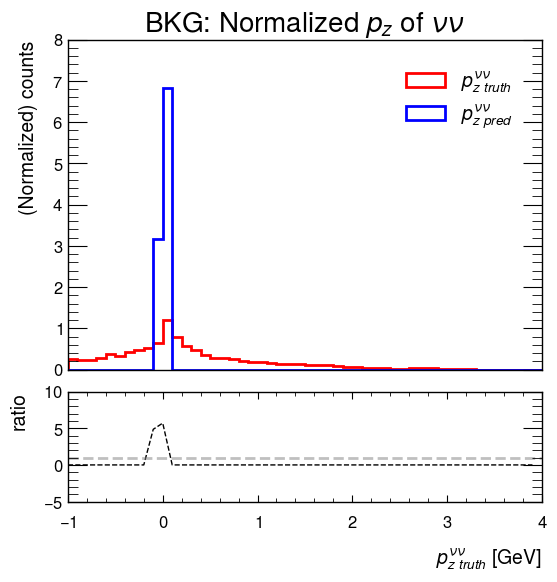

<Figure size 800x600 with 0 Axes>

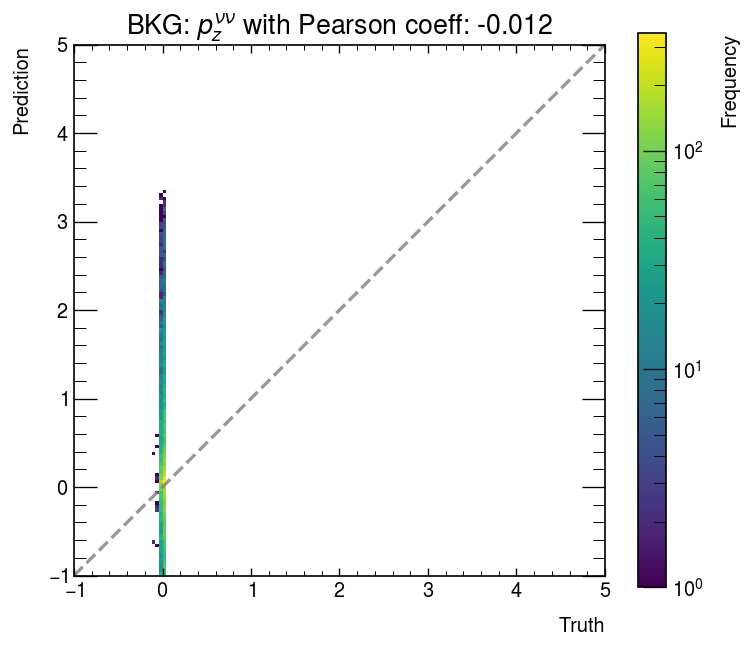

<Figure size 800x600 with 0 Axes>

In [49]:
plot = ap.Plotter()

plot.plot_hist(
    [truth, pred],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    "BKG: " + r"Normalized $p_{z}$ of $\nu\nu$",
    [-1, 4],
)

plot.plot_2d_histogram(
    pred,
    truth,
    "BKG: "
    + r"$p_{z}^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(truth, pred)[0]:.3f}",
    range=[-1, 5],
)